# GRU(Gated Recurrent Units) 모델
- https://arxiv.org/pdf/1406.1078
- LSTM의 RNN의 한계점인 기억력 소실문제를 해결하여 긴 sequence의 데이터에서도 좋은 성능을 내는 모델이다. 그러나 복잡한 구조로 parameter가 많아지게 되었고 연산량이 많은 문제점이 있다.
    - parameter가 많아지면서 데이터양이 부족할 경우 과대적합이 발생하고 연산량이 많아 학습에 많은 시간이 걸리게 된다.
- LSTM의 이런 문제를 개선하기 위한 변형 모델이 GRU이다.

## LSTM과 차이
1. LSTM은 forget gate, input gate, output gete 세개의 Gate연산을 함. GRU는 **reset gate와 update gate** 로 흐름을 제어한다.
2. LSTM은 이전 처리결과로 Cell State, Hidden State 두개가 있었는데 이것을 하나로 합쳐 **Hidden State**로 출력한다.

## GRU 성능
- GRU는 적은 파라미터 수와 연산비용이 적게 드는 것에 비해 LSTM과 비슷한 성능을 내는 것으로 알려졌다.

## GRU Cell 구조

![gru_cell](figures/rnn/23_gru_cell.png)    
[이미지 Source](https://www.oreilly.com/library/view/advanced-deep-learning/9781789956177/8ad9dc41-3237-483e-8f6b-7e5f653dc693.xhtml)

- **Reset Gate**
    - 이전 timestep까지의 hidden state(feature)를 현재 timestep의 hidden state(feature) 계산시 얼마나 반영할 지 비율을 결정하는 gate.
    - $r_{t} = \sigma(h_{t-1}\cdot U_{r} + X_{t}\cdot W_{r})$
        - $U_{r},\, W_{r}$ 는 파라미터
        - $\sigma$: sigmoid(logisic) 함수
- **Update Gate**
    - 현재 timestep의 hidden state($h_t$)를 계산할 때 이전 time step까지 정보($h_{t-1}$)와 현재 time step의 정보($X_t$)를 각각 얼마나 반영할지 비율을 정의한다.
    - $z_{t} = \sigma(h_{t-1}\cdot U_{z} + X_{t}\cdot W_{z})$
        - $U_{z},\, W_{z}$ 는 파라미터
        - $\sigma$: sigmoid(logisic) 함수
    - $h_t$를 계산할 때 $z_{t}$ 는 이전 정보인 $h_{t-1}$을 얼마나 반영할지 $1-z_{t}$는 현재 정보를 얼마나 반영할 지를 정한다.
- **Cell의 출력값인 $h_t$ 계산**
    - $z_{t}\times h_{t-1} + tanh(h_{t-1} * r_{t}+X_{t}\cdot W)\times(1-z_{t})$
    - 이전 정보에는 $z_t$를 곱해 얼마나 $h_t$ 에 더할지 연산
    - 현재 정보($X_t$)에는 이전 정보를 일부를 반영한다. 이전 정보를 얼마나 반영할지를 reset gate 결과를 곱해 결정한다. 활성화 함수 tanh를 이용해 비선형성을 추가 한 결과에 $1-z_t$를 곱한다.

## Pytorch GRU
- `nn.GRU` 클래스 이용
    - https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
- **입력**
    - **input**: (seq_length, batch, hidden_size) shape의 tensor. (batch_first=False), batch_first=True이면 `seq_length`와 `batch` 위치가 바뀐다.
    - **hidden**: (D * num_layers, batch, hidden_size) shape의 Tensor. D(양방향:2, 단방향:1), hidden은 생략하면 0이 입력됨.
- **출력** - output과 hidden state가 반환된다.
    - **output**
        - 모든 sequence의 처리결과들을 모아서 제공.
        - shape: (seq_length, batch, D * hidden_size) : D(양방향:2, 단방향:1), batch_first=True이면 `seq_length`와 `batch` 위치가 바뀐다.
    - **hidden**
        - 마지막 time step 처리결과
        - shape: (D * num_layers, batch, hidden) : D(양방향:2, 단방향:1)

In [1]:
# GRU 입출력 확인

import torch
import torch.nn as nn

# dummy data
input_data = torch.randn((20, 2, 10))  # (20 : seq, 2 : batch, 10 : 개별 timestep의 입력 feature수)

gru1 = nn.GRU(
    input_size=10,
    hidden_size=256,
    num_layers=1, # 몇 층 쌓을지
    bidirectional=False
)

out1, hidden = gru1(input_data)

print(out1.shape)  # 모든 timestep의 hidden state값 묶어서 반환  [20:seq_len, 2:batch, 256:hidden_size]
print(hidden.shape)  # 마지막 timestep 처리 hidden state 값 [1:seq len, 2, 256]

torch.Size([20, 2, 256])
torch.Size([1, 2, 256])


In [2]:
# bidirectional True

gru2 = nn.GRU(
    input_size=10,
    hidden_size=256,
    num_layers=1, # 몇 층 쌓을지
    bidirectional=True
)

out2, hidden2 = gru2(input_data)

print(out2.shape)  # 512 양방향 hidden state 합침
print(hidden2.shape)  # 2 정방향/역방향 2개, 256 : 따로 줌

torch.Size([20, 2, 512])
torch.Size([2, 2, 256])


In [3]:
#multi layer

gru3 = nn.GRU(
    input_size=10,
    hidden_size=256,
    num_layers=4, # 몇 층 쌓을지
    bidirectional=False
)

out3, hidden3 = gru3(input_data)

# [20, 2, 256] - 마지막 GRU Layer가 출력한 결과들이 최종 featrue이므로 그것을 모아서 반환 (layers가 몇개든 out의 shape 동일)
print(out3.shape)
# layer갯수만큼 출력함 (4) - 각 layer의 마지막 hidden state들을 모아서 반환
print(hidden3.shape)


torch.Size([20, 2, 256])
torch.Size([4, 2, 256])


In [4]:
# multi layer, 양방향

gru4 = nn.GRU(
    input_size=10,
    hidden_size=256,
    num_layers=4, # 몇 층 쌓을지
    bidirectional=True
)

out4, hidden4 = gru4(input_data)
print(out4.shape), print(hidden4.shape)

torch.Size([20, 2, 512])
torch.Size([8, 2, 256])


(None, None)

# Encoder-Decoder 구조
- 두개의 네트워크를 연결한 구조
- Encoder network는 입력을 이해하고 Decoder network는 (Encoder의 이해를 바탕으로) 출력을 생성한다.

## Seq2Seq
- Encoder-Decoder 구조를 RNN 계열에 적용한 모델.
- Encoder는 입력 Sequence의 전체 의미(특징)을 표현하는 **context vector**를 출력한다.
    - **Context Vector는**
        - 번역의 경우 번역할 대상 문장에서 **번역 결과를 만들때 필요한 feature들**을 가지고 있다.
        - Chatbot의 경우 입력된 질문에서 **답변을 만들때 필요한 feature들**을 가지고 있다.
- Decoder는 Encoder가 출력한 Context Vector를 입력받아 결과 sequence를 생성한다.
    - **결과 sequence는**
        - **번역**의 경우 번역 문장을 생성한다.
        - **chatbot**의 경우 질문에 대한 답변을 생성한다.

![seq2seq](figures/seq2seq.png)

# Seq2Seq 를 이용한 Chatbot 모델 구현
- Encoder를 이용해 질문의 특성을 추출하고 Decoder를 이용해 답변을 생성한다.

# Chatbot Dataset

- https://github.com/songys/Chatbot_data
- columns
    - Q: 질문
    - A: 답
    - label: 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2
- **Download**

![dataset](figures/chatbot.png)

# Chatbot Dataset Loading 및 확인

## 데이터 확인

In [5]:
# requests로 받기
import requests
import os

os.makedirs('data', exist_ok=True)

url = 'https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv'
res = requests.get(url)

if res.status_code == 200 :
    with open('data/chat_bot_data.csv', 'wt', encoding='utf-8') as fw :
        fw.write(res.text)
else :
    print(f'불러오지 못함 {url}')

In [6]:
import pandas as pd

df = pd.read_csv('data/chat_bot_data.csv')
df.shape

(11823, 3)

In [7]:
print(df.info())

df.drop(columns='label', inplace=True)
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB
None


,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


# Dataset, DataLoader 정의

## Tokenization

### Subword방식

In [8]:
# token 학습 -> vocab 사전 생성
## 질문들 + 답변들 합쳐서 학습

question_texts = df['Q']
answer_texts = df['A']

all_text = list(question_texts + ' ' + answer_texts) # series + series
all_text

['12시 땡! 하루가 또 가네요.',
 '1지망 학교 떨어졌어 위로해 드립니다.',
 '3박4일 놀러가고 싶다 여행은 언제나 좋죠.',
 '3박4일 정도 놀러가고 싶다 여행은 언제나 좋죠.',
 'PPL 심하네 눈살이 찌푸려지죠.',
 'SD카드 망가졌어 다시 새로 사는 게 마음 편해요.',
 'SD카드 안돼 다시 새로 사는 게 마음 편해요.',
 'SNS 맞팔 왜 안하지ㅠㅠ 잘 모르고 있을 수도 있어요.',
 'SNS 시간낭비인 거 아는데 매일 하는 중 시간을 정하고 해보세요.',
 'SNS 시간낭비인데 자꾸 보게됨 시간을 정하고 해보세요.',
 'SNS보면 나만 빼고 다 행복해보여 자랑하는 자리니까요.',
 '가끔 궁금해 그 사람도 그럴 거예요.',
 '가끔 뭐하는지 궁금해 그 사람도 그럴 거예요.',
 '가끔은 혼자인게 좋다 혼자를 즐기세요.',
 '가난한 자의 설움 돈은 다시 들어올 거예요.',
 '가만 있어도 땀난다 땀을 식혀주세요.',
 '가상화폐 쫄딱 망함 어서 잊고 새출발 하세요.',
 '가스불 켜고 나갔어 빨리 집에 돌아가서 끄고 나오세요.',
 '가스불 켜놓고 나온거 같아 빨리 집에 돌아가서 끄고 나오세요.',
 '가스비 너무 많이 나왔다. 다음 달에는 더 절약해봐요.',
 '가스비 비싼데 감기 걸리겠어 따뜻하게 사세요!',
 '가스비 장난 아님 다음 달에는 더 절약해봐요.',
 '가장 확실한 건 뭘까? 가장 확실한 시간은 오늘이에요. 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요.',
 '가족 여행 가기로 했어 온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '가족 여행 고고 온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '가족 여행 어디로 가지? 온 가족이 모두 마음에 드는 곳으로 가보세요.',
 '가족 있어? 저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '가족관계 알려 줘 저를 만들어 준 사람을 부모님, 저랑 이야기해 주는 사람을 친구로 생각하고 있어요',
 '가족끼리 여행간다

In [9]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

vocab_size = 10000
min_frequency = 5 # 최소 5번은 나온 토큰

tokenizer = Tokenizer(BPE(unk_token='[UNK]'))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(
    vocab_size=vocab_size,
    min_frequency = min_frequency,
    continuing_subword_prefix = '##',
    special_tokens=['[PAD]', '[UNK]', '[SOS]'] # sos 문장 시작
)

# 학습
tokenizer.train_from_iterator(all_text, trainer=trainer)
# tokenizer.train('파일경로') : 파일에 있는 텍스트 학습

print(f'총 어휘 수 : {tokenizer.get_vocab_size()}')




총 어휘 수 : 7040


In [10]:
ecode = tokenizer.encode('오늘 날씨 좋습니다 좋은 하루 되세요')
print(ecode.ids)
print(ecode.tokens)

[2290, 2841, 5913, 2272, 2447, 322, 2243]
['오늘', '날씨', '좋습니다', '좋은', '하루', '되', '##세요']


### Tokenizer 저장

In [11]:
os.makedirs('saved_model/vocab', exist_ok=True)
vocab_path = os.path.join('saved_model/vocab', 'chatbot_bpe.json')
tokenizer.save(vocab_path)

## Dataset, DataLoader 정의


### Dataset 정의 및 생성
- 모든 문장의 토큰 수는 동일하게 맞춰준다.
    - DataLoader는 batch 를 구성할 때 batch에 포함되는 데이터들의 shape이 같아야 한다. 그래야 하나의 batch로 묶을 수 있다.
    - 문장의 최대 길이를 정해주고 **최대 길이보다 짧은 문장은 `<PAD>` 토큰을 추가**하고 **최대길이보다 긴 문장은 최대 길이에 맞춰 짤라준다.**

In [12]:
import random
import os
import numpy as np
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
class ChatbotDataset(Dataset):
    """
    ChatbotDataset
    parameter:
        question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
        answer_texts: list[str] - 답 texts 목록. 리스트에 답변들을 담아서 받는다.     ["답1", "답2", ...]
        max_length: 개별 문장의 token 개수. 모든 문장의 토큰수를 max_length에 맞춘다.
        tokenizer: Tokenizer
        vocab_size: int 총단어수
    """
    def __init__(self, question_texts, answer_texts, max_length, tokenizer):
        """
        parameter
            question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
            answer_texts: list[str] - 답 texts 목록. 리스트에 답변들을 담아서 받는다.     ["답1", "답2", ...]
            max_length: 개별 문장의 token 개수. 모든 문장의 토큰수를 max_length에 맞춘다.
            tokenizer: Tokenizer
        """
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.question_texts = [self.__process_sequence(q) for q in question_texts]
        self.answer_texts = [self.__process_sequence(a) for a in answer_texts]
    
    def __pad_token_sequence(self, token_sequence):
        """
        max_length 길이에 맞춰 token_id 리스트를 구성한다.
        max_length 보다 길면 뒤에를 자르고 max_length 보다 짧으면 [PAD] 토큰을 추가한다.
        
        Parameter
            token_sentence: list[int] - 길이를 맞출 한 문장 token_id 목록
        Return
            list[int] - length가 max_length인 token_id 목록
        """
        pad_token = self.tokenizer.token_to_id('[PAD]')
        seq_len = len(token_sequence)

        if seq_len > self.max_length :
            return token_sequence[:self.max_length]
        else :
            return token_sequence + ([pad_token] * (self.max_length - seq_len))
    
    
    def __process_sequence(self, text):
        """
        한 문장을 받아서 padding이 추가된 token_id 리스트로 변환 후 반환
        Parameter
            text: str - token_id 리스트로 변환할 한 문장
        Return
            list[int] - 입력받은 문장에 대한 token_id 리스트
        """
        encode = self.tokenizer.encode(text)
        #max_length 크기에 맞춘다
        token_ids = self.__pad_token_sequence(encode.ids)
        return token_ids

    
    def __len__(self):
        return len(self.question_texts)

    
    def __getitem__(self, index):
        #return (질문토큰들, 답변토큰들)
        q = self.question_texts[index]
        a = self.answer_texts[index]
        # list -> longtensor로 변환 nn.Embedding()의 입력(정수타입)으로 들어가기 때문에 변경
        return torch.tensor(q, dtype=torch.int64), torch.tensor(a, dtype=torch.int64)
        

In [14]:
# 적당한 max_length 값 : 전체 문장 총 토큰수의 9분위 수
import numpy as np

a = [len(s) for s in all_text]
np.quantile(a, q=[0.9, 0.95, 1.0])

#max_length = 20

array([42., 48., 91.])

(array([8.000e+00, 1.200e+01, 8.000e+01, 2.870e+02, 7.170e+02, 1.250e+03,
        1.509e+03, 1.632e+03, 1.539e+03, 1.224e+03, 9.380e+02, 7.180e+02,
        6.000e+02, 4.080e+02, 1.940e+02, 2.370e+02, 1.630e+02, 9.700e+01,
        8.500e+01, 3.800e+01, 2.600e+01, 2.400e+01, 1.400e+01, 9.000e+00,
        3.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 2.000e+00, 2.000e+00]),
 array([ 3.        ,  5.93333333,  8.86666667, 11.8       , 14.73333333,
        17.66666667, 20.6       , 23.53333333, 26.46666667, 29.4       ,
        32.33333333, 35.26666667, 38.2       , 41.13333333, 44.06666667,
        47.        , 49.93333333, 52.86666667, 55.8       , 58.73333333,
        61.66666667, 64.6       , 67.53333333, 70.46666667, 73.4       ,
        76.33333333, 79.26666667, 82.2       , 85.13333333, 88.06666667,
        91.        ]),
 <BarContainer object of 30 artists>)

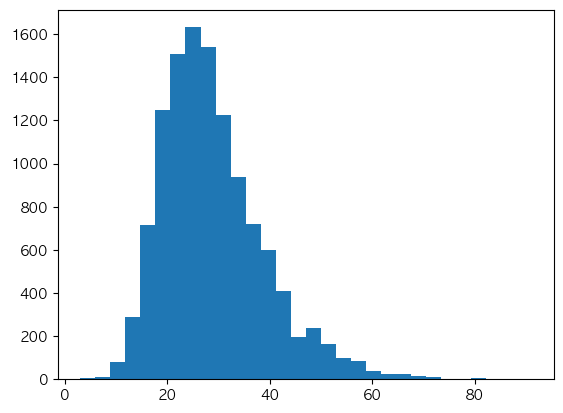

In [15]:
import matplotlib.pyplot as plt

plt.hist(a, 30)

In [60]:
# dataset 생성
MAX_LENGTH = 20
dataset = ChatbotDataset(question_texts, answer_texts, MAX_LENGTH, tokenizer)

dataset[0]

(tensor([  10, 1622, 1287,  368,    3,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([6119,  378,   47, 2252,    8,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]))

### Trainset / Testset 나누기
train : test = 8 : 2

In [61]:
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size

print(train_size, test_size)

10640 1183


In [89]:
train_set, test_set = random_split(dataset, [train_size, test_size]) #shuffle 후 갯수에 맞게 나눔

### DataLoader 생성

In [90]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

# 모델 정의

## Seq2Seq 모델 정의
- Seq2Seq 모델은 Encoder와 Decoder의 입력 Sequence의 길이와 순서가 자유롭기 때문에 챗봇이나 번역에 이상적인 구조다.
    - 단일 RNN은 각 timestep 마다 입력과 출력이 있기 때문에 입/출력 sequence의 개수가 같아야 한다.
    - 챗봇의 질문/답변이나 번역의 대상/결과 문장의 경우는 사용하는 어절 수가 다른 경우가 많기 때문에 단일 RNN 모델은 좋은 성능을 내기 어렵다.
    - Seq2Seq는 **입력처리(질문,번역대상)처리 RNN과 출력 처리(답변, 번역결과) RNN 이 각각 만들고 그 둘을 연결한 형태로 길이가 다르더라도 상관없다.**

## Encoder
Encoder는 하나의 Vector를 생성하며 그 Vector는 **입력 문장의 의미**를 N 차원 공간 저장하고 있다. 이 Vector를 **Context Vector** 라고 한다.    
![encoder](figures/seq2seq_encoder.png)

In [91]:
class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_size, bidirectional = True, num_layers = 1, dropout_rate = 0.0):
        super().__init__()
        # Encoder는 context vector(문장의 feature) 를 생성하는 것이 목적 (분류기느 생성 안 함)
        # Embedding Layer, GRU Layer를 생성
        self.vocab_size = vocab_size # 어휘사전의 총 어휘 수(토큰수)
        # Embedding layer
        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,  # embedding vector shape: [vocab_size, embedding_dim]
            padding_idx=0
        )
        # GRU
        self.gru = nn.GRU(
            embedding_dim, # 개별 토큰(time step)의 크기
            hidden_size,
            num_layers = num_layers,
            bidirectional = bidirectional,
            dropout = dropout_rate
        )

    def forward(self, X):
        X = self.embedding(X) # (batch, seq_len, embedding_dim)
        X = X.transpose(1, 0) # (seq_len, batch, embedding_dim)
        out, hidden = self.gru(X)
        return out, hidden


In [92]:
from torchinfo import summary
encoder_model = Encoder(1000, 200, 256)
dummy_data = torch.zeros((64, 20), dtype=torch.int64)
summary(encoder_model, input_data=dummy_data)

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [20, 64, 512]             --
├─Embedding: 1-1                         [64, 20, 200]             200,000
├─GRU: 1-2                               [20, 64, 512]             703,488
Total params: 903,488
Trainable params: 903,488
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 913.26
Input size (MB): 0.01
Forward/backward pass size (MB): 7.29
Params size (MB): 3.61
Estimated Total Size (MB): 10.92

## Decoder
- Encoder의 출력(context vector)를 받아서 번역 결과 sequence를 출력한다.
- Decoder는 매 time step의 입력으로 **이전 time step에서 예상한 단어와 hidden state값이** 입력된다.
- Decoder의 처리결과 hidden state를 Estimator(Linear+Softmax)로 입력하여 **입력 단어에 대한 번역 단어가 출력된다.** (이 출력단어가 다음 step의 입력이 된다.)
    - Decoder의 첫 time step 입력은 문장의 시작을 의미하는 <SOS>(start of string) 토큰이고 hidden state는 context vector(encoder 마지막 hidden state) 이다.

![decoder](figures/seq2seq_decoder.png)

In [129]:
class Decoder(nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=1, bidriectional=False, dropout_rate=0.0) :
        super().__init__()
        self.vocab_size = vocab_size # 총 어휘사전 토큰 갯수
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        #GRU
        # Auto regressive RNN은 단방향만 가능
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout_rate)
    
        #drop out layer
        self.dropout = nn.Dropout(dropout_rate)

        #분류기 (다음 단어 추론) - 다중 분류 (단어 사전의 단어들 중 다음 단어일 확률)
        self.lr = nn.Linear(
            hidden_size, # GRU 출력 값 중 마지막 hidden state값을 입력으로 받음
            vocab_size # 출력 : 다음 단어일 확률
        )

    def forward(self, X, hidden) :
        # X = torch.LongTensor : shape - [batch] 한 단어씩 입력을 받음
        # hidden = torch.FloatTensor : shape - [1, batch, hidden_size] (이전까지의 특성)
         X = X.unsqueeze(1) # seq_len 축을 추가 [batch] -> [1, batch]
         X = self.embedding(X) # [batch, 1, embedding차원]
         X = X.transpose(1,0) # [1, batch embedding차원]
         out, hidden = self.gru(X, hidden)
         last_out = out[-1] # out : 전체 hidden state값 -> 마지막 hidden state을 추출
         last_out = self.lr(last_out)
         return last_out, hidden # (hidden : 다음 timestep에 전달)

In [130]:
# summary
decoder_model = Decoder(1000, 200, 256)
dummy_input = torch.ones((64,), dtype=torch.int64)
dummy_hidden = torch.ones((1, 64, 256), dtype=torch.float32)

summary(decoder_model, input_data=(dummy_input, dummy_hidden))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [64, 1000]                --
├─Embedding: 1-1                         [64, 1, 200]              200,000
├─GRU: 1-2                               [1, 64, 256]              351,744
├─Linear: 1-3                            [64, 1000]                257,000
Total params: 808,744
Trainable params: 808,744
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 51.76
Input size (MB): 0.07
Forward/backward pass size (MB): 0.75
Params size (MB): 3.23
Estimated Total Size (MB): 4.05

## Seq2Seq 모델

- Encoder - Decoder 를 Layer로 가지며 Encoder로 질문의 feature를 추출하고 Decoder로 답변을 생성한다.

### Teacher Forcing
- **Teacher forcing** 기법은, RNN계열 모델이 다음 단어를 예측할 때, 이전 timestep에서 예측된 단어를 입력으로 사용하는 대신 **실제 정답 단어(ground truth) 단어를** 입력으로 사용하는 방법이다.
    - 모델은 이전 시점의 출력 단어를 다음 시점의 입력으로 사용한다. 그러나 모델이 학습할 때 초반에는 정답과 많이 다른 단어가 생성되어 엉뚱한 입력이 들어가 학습이 빠르게 되지 않는 문제가 있다.
- **장점**
    - **수렴 속도 증가**: 정답 단어를 사용하기 때문에 모델이 더 빨리 학습할 수있다.
    - **안정적인 학습**: 초기 학습 단계에서 모델의 예측이 불안정할 때, 잘못된 예측으로 인한 오류가 다음 단계로 전파되는 것을 막아줍니다.
- **단점**
    - **노출 편향(Exposure Bias) 문제:** 실제 예측 시에는 정답을 제공할 수 없으므로 모델은 전단계의 출력값을 기반으로 예측해 나가야 한다. 학습 과정과 추론과정의 이러한 차이 때문에 모델의 성능이 떨어질 수있다.
        - 이런 문제를 해결하기 학습 할 때 **Teacher forcing을 random하게 적용하여 학습시킨다.**
![seq2seq](figures/seq2seq.png)

In [131]:
SOS_TOKEN = tokenizer.token_to_id('[SOS]')

class Seq2Seq(nn.Module) :
    
    def __init__(self, encoder, decoder, device) :
        super().__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device

    def forward(self, inputs, outputs, teacher_forcing_rate=0.99) :
        '''
        parameter
            inputs : 질문 - (batch, seq_length)
            outputs : 답변(정답) - (batch, seq_length)
            teacher_forcing_rate : teacher_forcing 적용 확률
        '''
        if inputs.dim() == 1: # (seq_length) 질문이 1개일 경우 질문 문장 토큰만 입력 될 수있다
            inputs = inputs.unsqueeze(0) # (1, seq_length)
        if outputs.dim() == 1:
            outputs = outputs.unsqueeze(0)

        batch_size, output_length = outputs.shape
        output_vocab_size = self.decoder.vocab_size # 어휘 사전 토큰 갯수

        # 생성된 문장을 저장할 변수
        ## (seq length, batch_size, vocab_size(단어별 확률))
        predicted_outputs = torch.zeros(output_length, batch_size, output_vocab_size).to(self.device)

        ## encoder를 이용해서 질문의 context vector 추출
        encoder_out, encoder_hidden = self.encoder(inputs)
        #encoder_out : [seq_len, batch, hidden_size * 2(양방향)]

        #encoder_hidden : [2(양방향), batch, hidden_size]
        decoder_hidden = encoder_out[-1].unsqueeze(0) # [1, batch_size]

        #decoder에 넣을 첫번째 timestep값 : [SOS]
        decoder_input = torch.full((batch_size,), fill_value=SOS_TOKEN, device=self.device)

        # 순회하면서 단어들을 하나씩 생성
        for t in range(output_length) :   #max_length 만큼 생성
            # decoder_input(개별 단어 토큰 id) : [batch_size] - 첫 timestep : SOS, 두번째 : 생성된 토큰
            # decoder_out(batch_size, vocab_size) : 다음 단어일 확률
            # decoder_hidden(1, batch_size, hidden * 2(양방향)) - 현재 입력의 feature 다음 hidden
            decoder_out, decoder_hidden = self.decoder(decoder_input, decoder_hidden)

            predicted_outputs[t] = decoder_out # t번째 예측 단어를 저장

            ### 다음 timestep에 넣어줄 값 생성
            ### teacher_forcing 적용 : 정답, 비적용 : 모델이 추론한 결과
            teacher_forcing = teacher_forcing_rate > random.random()
            # teacher_forcing_rate의 확률만큼 True
            teacher_forcing_rate = teacher_forcing_rate * 0.99  # 점점 teacher_forcing 가능성 줄임

            # 모델이 추론한 단어 중 가장 확률이 높은 (Top1) 단어를 추출
            top1 = decoder_out.argmax(-1)
            # teacher_forcing이 True 정답, False : 예측 
            decoder_input = outputs[:, t] if teacher_forcing else top1
            
        return predicted_outputs.transpose(1,0) # (batch, seq_length, vocab_size) 변환

# 학습

## 모델생성

In [132]:
# 하이퍼 파라미터 생성
VOCAB_SIZE = tokenizer.get_vocab_size()

ENCODER_BIDIRECTIONAL = True # 인코더 양방향 여부
ENCODER_HIDDEN_SIZE = 200
DECODER_HIDDEN_SIZE = ENCODER_HIDDEN_SIZE * 2 if ENCODER_BIDIRECTIONAL else ENCODER_HIDDEN_SIZE
EMBEDDING_DIM = 256 # 임베딩 차원
TEACHER_FORCING_RATE = 0.9

In [133]:
# 모델 생성
encoder = Encoder(
    vocab_size = VOCAB_SIZE,
    embedding_dim = EMBEDDING_DIM,
    hidden_size = ENCODER_HIDDEN_SIZE,
    bidirectional = ENCODER_BIDIRECTIONAL,
    num_layers=1
)

# 모델 생성
decoder = Decoder(
    vocab_size = VOCAB_SIZE,
    embedding_dim = EMBEDDING_DIM,
    hidden_size = DECODER_HIDDEN_SIZE,
    num_layers=1
)

model = Seq2Seq(encoder, decoder, device)

## loss함수, optimizer

In [134]:
LR = 0.001
model = model.to(device)
# 다음 단어를 추론하는 다중 분류
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

## train/evaluation 함수 정의

### train 함수정의

In [135]:
# epoch 학습 함수
def train_fn(model, data_loader, optimizer, loss_fn, device, teacher_forcing_rate=0.99) :
    model.train()
    loss_list = []

    for X, y in data_loader :
        X, y = X.to(device), y.to(device)
        #추론
        pred = model(X, y, teacher_forcing_rate)
        # pred : 추론한 답변 문장 (batch, seq_length, vocab_size: 토큰일 확률)

        #pred와 정답의 shape을 변경 (loss에 넣을수있는 shape으로 변환)
        #pred를 reshape (batch, seq_len, vocab_size) -> (batch*seq_len, vocab_size)
        y_hat = pred.reshape(-1, pred.shape[2])
        # 정답(y)을 reshape (batch, seq_len) -> (batch * seq_len)
        y = y.reshape(-1)
        # CrossEntropyLoss(): 정답 - 원핫인코딩 안된 형태, 추론값: softmax 처리 안된 상태
        #       - 정답  shape: (batch, )
        #       - 추론값shape: (batch, class개수)
        #Loss 계산
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_list.append(loss.item())
    return np.mean(loss_list)


### Test 함수

In [140]:
def test_fn(model, data_loader, loss_fn, device) :

    # 1. 에폭 테스트
    model.eval()
    loss_list = []

    with torch.no_grad() :
        for X, y in data_loader :
            X, y = X.to(device), y.to(device)
            pred = model(X, y, teacher_forcing_rate=0.0)
            y_hat = pred.reshape(-1, pred.shape[2])
            y = y.reshape(-1)
            loss_list.append(loss_fn(y_hat, y).item())
            
    return np.mean(loss_list)

### Training

In [141]:
EPOCHS = 10
MODEL_SAVE_PATH = 'saved_model/seq2seq2-chatbot-model.pt'

best_loss = np.inf

for epoch in range(EPOCHS) :
    train_loss = train_fn(model, train_loader, optimizer, loss_fn, device, TEACHER_FORCING_RATE)
    val_loss = test_fn(model, test_loader, loss_fn, device)

    # 저장
    if val_loss < best_loss :
        torch.save(model, MODEL_SAVE_PATH)
        print(f'{epoch}에서 저장. {best_loss:.5f}에서 {val_loss:.5f}로 개선 됨')
        best_loss = val_loss

    print(f'[{epoch}/{EPOCHS}] train loss : {train_loss}, val loss : {val_loss}')

0에서 저장. inf에서 2.62633로 개선 됨
[0/10] train loss : 1.737084824636758, val loss : 2.626334642109118
[1/10] train loss : 1.5191522635609271, val loss : 2.6666539844713713
[2/10] train loss : 1.3156407360570976, val loss : 2.76448120568928
[3/10] train loss : 1.100205335631428, val loss : 3.00342909913314
[4/10] train loss : 0.9316974907036287, val loss : 3.0219767470108834
[5/10] train loss : 0.7947534595627382, val loss : 3.19746826824389
[6/10] train loss : 0.7240790678075997, val loss : 3.1240621491482385
[7/10] train loss : 0.6323503841118641, val loss : 3.353264670622976
[8/10] train loss : 0.49272662760263464, val loss : 3.497721559122989
[9/10] train loss : 0.4510383440787534, val loss : 3.5147845996053597


In [143]:
MODEL_SAVE_PATH_LAST = 'saved_model/seq2seq-chatbot-model_last.pt'
torch.save(model, MODEL_SAVE_PATH_LAST)

In [144]:
## 저장 모델 Load
device = "cuda" if torch.cuda.is_available() else "cpu"
# map_location=device: 다른 device에 학습한 것을 읽어올 때 현재 device를 지정해서 현재 device에 맞춰 load하도록 한다.
best_model = torch.load(MODEL_SAVE_PATH, weights_only=False, map_location=device)
best_model.device = device # Attribute device를 현재 device로 지정. 

last_model = torch.load(MODEL_SAVE_PATH_LAST, weights_only=False, map_location=device)
last_model.device = device # Attribute device를 현재 device로 지정. 

# 결과확인

In [207]:
from torch.utils.data import SubsetRandomSampler


def handle_special_tokens(decoded_string):
    """
    Subword 처리
    subword는 단어의 시작으로 쓰인 것과 중간 부분(연결)에 사용된 두가지 subword가 있다.  연결 subword는 `#`과 같은 특수문자로 시작 한다.
    tokenizer.decode() 결과 문자열은 subword의 특수문자('#')을 처리하지 않는다. 이것을 처리하는 함수
    ex) "이 기회 #는 내 #꺼 #야" ==> "이 기회는 내꺼야"
    
    Parameter
        decoded_string: str - Tokenizer가 decode한 중간 subword의 특수문자 처리가 안된 문자열. 
    Return
        str: subword 특수문자 처리한 문자열
    """
    tokens = decoded_string.split() # 공백 기준으로 토큰화
    new_tokens = []
    for token in tokens :
        if token.startswith('##') : # 연결토큰
            if new_tokens : # len(new_tokens) != 0 원소가 하나라도 있으면 토큰에서 ## 제거하고 리스트의 마지막 원소 뒤에 붙임
                new_tokens[-1] += token[2:]
            else :
                new_tokens.append(token[2:])
        else :  # 단어의 시작인 토큰 (##이 없는 토큰) -> List에 추가
            new_tokens.append(token)

    return " ".join(new_tokens)  

# dataset에서 일부 데이터들을 가지고 확인
def random_evaluation(model, dataset, device, n=10):
    """
    Dataset에서 일부 질문-답변 쌍들을 가져다 모델에 질문을 넣어 추론한 결과와 함께 확인.
    Parameter
        model: 학습된 seq2seq 모델
        dataset: 질문-답변 쌍울 추출할 dataset
        device
        n: int - 추출할 질문-답변 쌍 개수 default: 10
    """
    ## 평가할 데이터셋 만들기
    no_samples = len(dataset)
    index = list(range(no_samples))
    np.random.shuffle(index)
    sample_index = index[ : n  ]

    #dataloader 생성
    # SubsetRandomSampler : 지정한 Index안에서 random한 순서로 제공
    sampler = SubsetRandomSampler(sample_index)
    sample_loader = DataLoader(dataset, batch_size=n, sampler=sampler)

    #추론 후 확인
    model.to(device)
    model.eval()
    with torch.no_grad() :
        for X, y in sample_loader :
            X, y = X.to(device), y.to(device)
            output = model(X, y, 0.0)  # [batch, seq_len, vocab_size]

            # torch.Tensor -> ndarray (tokenizer decode에 넣기 위해)
            # tensor -> cpu로 이동 후에 변환가능
            # tensor가 gradient를 가지고있으면 -> tensor.detach().cpu().ndarray()로 바꿔야함
            pred = output.cpu().numpy()
            X = X.cpu().numpy()
            y = y.cpu().numpy()

            for i in range(n) :
                q = handle_special_tokens(tokenizer.decode(X[i]))
                a = handle_special_tokens(tokenizer.decode(y[i]))
                p = handle_special_tokens(tokenizer.decode(pred[i].argmax(-1)))

                print(f'질문 : {q}')
                print(f'정답 : {a}')
                print(f'예측 : {p}')
                print('===================================================')
                




Sampler:
- DataLoader가 Dataset의 값을 읽어서 batch를 만들때 index 순서를 정해주는 객체.
- DataLoader의 기본 sampler는 SequentialSampler 이다. shuffle=True일 경우 RandomSampler: 랜덤한 순서로 제공.

In [202]:
e = tokenizer.encode("일부 질문-답변 쌍들을 가져다 모델에 질문")
txt = tokenizer.decode(e.ids)
txt

'일 ##부 질문 - 답 ##변 쌍 ##들을 가져 ##다 모 ##델 ##에 질문'

In [208]:
handle_special_tokens(txt)

'일부 질문 - 답변 쌍들을 가져다 모델에 질문'

In [209]:
print('===============BEST MODEL=================')
random_evaluation(best_model, test_set, device)

===============BEST MODEL=================
질문 : 여자친구가 데이트 시간을 너무 안 지켜 .
정답 : 준비하느라 오래걸리는 친구를 이해해주세요 .
예측 : 마음이 복잡하겠어요 .
질문 : 집 사고 싶어
정답 : 같이 살고 싶은 사람이 있나봐요 .
예측 : 좋은 사람 만날 수 있을 거예요 .
질문 : 술 잘하니
정답 : 저는 주당이에요 .
예측 : 좋은 사람 만날 수 있을 거예요 .
질문 : 열받아서 막 전화에다가 화풀이했어
정답 : 속이 좀 풀렸길 발바니다 .
예측 : 좋은 사람 만날 수 있을 거예요 .
질문 : 짝사랑하는 사람에 대한 마음이 갑자기 식었어 .
정답 : 무슨 계기가 있었을지도 몰라요 .
예측 : 마음이 복잡하겠어요 .
질문 : 사과해야 하나 ?
정답 : 사과할 건 사과해야죠 .
예측 : 마음이 따뜻할 것 같아요 .
질문 : 남편이 효자인 거 같아
정답 : 좋게 생각해보세요 .
예측 : 좋은 사람 만날 수 있을 거예요 .
질문 : 존경할 수 있는 사람 만나고 싶어 .
정답 : 그런 사람 만날 수 있을 거예요 .
예측 : 좋은 사람 만날 수 있을 거예요 .
질문 : 버스 멀미하는 것 같아
정답 : 핸드폰 만지지 마세요 .
예측 : 좋은 사람 만날 수 있을 거예요 .
질문 : 포기안한다고 말했어
정답 : 마음이 힘들겠어요 .
예측 : 좋은 사람 만날 수 있을 거예요 .


# 새로운 데이터 추론

In [191]:
class ChatbotIDataset(Dataset):
    """
    ChatbotInputDataset
    질문만 받아서 생성하는 Dataset
    - 새로운 데이터 추론용
    """
    def __init__(self, question_texts, max_length, tokenizer):
        """
        parameter
            question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
            max_length: 개별 문장의 token 개수. 모든 문장의 토큰수를 max_length에 맞춘다.
            tokenizer: Tokenizer
        """
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.question_texts = [self.__process_sequence(q) for q in question_texts]
    
    def __pad_token_sequence(self, token_sequence):
        """
        max_length 길이에 맞춰 token_id 리스트를 구성한다.
        max_length 보다 길면 뒤에를 자르고 max_length 보다 짧으면 [PAD] 토큰을 추가한다.
        
        Parameter
            token_sentence: list[int] - 길이를 맞출 한 문장 token_id 목록
        Return
            list[int] - length가 max_length인 token_id 목록
        """
        pad_token = self.tokenizer.token_to_id('[PAD]')
        seq_len = len(token_sequence)

        if seq_len > self.max_length :
            return token_sequence[:self.max_length]
        else :
            return token_sequence + ([pad_token] * (self.max_length - seq_len))
    
    
    def __process_sequence(self, text):
        """
        한 문장을 받아서 padding이 추가된 token_id 리스트로 변환 후 반환
        Parameter
            text: str - token_id 리스트로 변환할 한 문장
        Return
            list[int] - 입력받은 문장에 대한 token_id 리스트
        """
        encode = self.tokenizer.encode(text)
        #max_length 크기에 맞춘다
        token_ids = self.__pad_token_sequence(encode.ids)
        return token_ids

    
    def __len__(self):
        return len(self.question_texts)

    
    def __getitem__(self, index):
        #return (질문토큰들, 답변토큰들)
        q = self.question_texts[index]
        # list -> longtensor로 변환 nn.Embedding()의 입력(정수타입)으로 들어가기 때문에 변경
        return torch.tensor(q, dtype=torch.int64)
        

In [192]:
input_data = [
    '집에 가고싶어',
    '재밌는거 없을까?',
    '지금 몇 시예요'
]

input_dataset = ChatbotIDataset(input_data, MAX_LENGTH, tokenizer)

In [212]:
def predict(dataset, model, device) :
    model.eval()
    model.to(device)
    with torch.no_grad() :
        for X in dataset :
            X = X.to(device)
            output = model(X.unsqueeze(0), X.unsqueeze(0), 0.0)
            pred = output.cpu().numpy()
            X = X.cpu().numpy()
            q = handle_special_tokens(tokenizer.decode(X))
            a = handle_special_tokens(tokenizer.decode(pred[0].argmax(-1)))

            print(f'질문 : {q}')
            print(f'예상 답 : {a}')

In [213]:
predict(input_dataset, last_model, device)

질문 : 집에 가고싶어
예상 답 : 저도 딸기 좋아해요 . 같이 가요 .
질문 : 재밌는거 없을까 ?
예상 답 : 혼자 풀릴 때까지 놔둬야하는데 기다리는게 힘들 거예요 .
질문 : 지금 몇 시예요
예상 답 : 성공을 빌어요 .
